In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np
import math
from sklearn import datasets
from matplotlib import pyplot as plt
import pandas as pd




In [13]:
def LAR_LASSO(X,Y):
    
    n = np.shape(X)[0]
    p = np.shape(X)[1]
    mu_hat = np.zeros(n)
    beta = np.zeros(p)
    beta_process = [beta]
    c = np.dot(X.T,Y)
    A = [np.argmax(abs(c))]
    A_process = [A]
    c_process = []
    C = max(abs(c))
    while(C != 0):
        c = np.dot(X.T,Y- mu_hat)
        c_process.append(c)
        C = max(abs(c))
        S = np.sign(c)
#         sign_X_A = X[:,A]*S
        sign_X_A = X[:,A]*S[A]
        
        ##计算等角向量
        X_tX_inverse = np.array(np.mat(np.dot(sign_X_A.T,sign_X_A)).I)
        W_A = C * np.dot(X_tX_inverse,np.ones(len(A)))
        U_A =  np.dot(sign_X_A,W_A)
        a = np.dot(X.T,U_A)
        gamma = np.ones(p)
        
        #确定步长
        for j in set(range(p)) - set(A):
            gamma1 = (C - c[j])/ (C - a[j])
            gamma2 = (C + c[j])/ (C + a[j])
            if (min(gamma1,gamma2) > 0): 
                gamma[j] = min(gamma1,gamma2)
            elif (max(gamma1,gamma2)> 0):
                gamma[j] = max(gamma1,gamma2)

        
        for j in A:
            if (-beta[j] / S[j] *W_A[A.index(j)]) > 0:
                gamma[j] = - beta[j]/ (S[j] *  W_A[A.index(j)]) 
        
        gamma_hat = min(gamma)
        if gamma_hat == 1:
            d = np.zeros(p)
            d[A] = gamma_hat * S[A] * W_A
            beta = beta + d
            mu_hat = mu_hat + gamma_hat * U_A
            beta_process.append(beta)
            break
        else:
            j_hat = np.argmin(gamma)
        
        
        ##系数的变化
        d = np.zeros(p)
        d[A] = gamma_hat * S[A] * W_A
        beta = beta + d
        mu_hat = mu_hat + gamma_hat * U_A
        beta_process.append(beta)

        if j_hat in A:
            A.remove(j_hat)

        else:
            A.append(j_hat)
            
        A_process.append(A)
        C =  (1 - gamma_hat) * C 
    
    xx = np.sum(np.abs(beta_process),axis = 1)
    xx /= xx[-1]
    plt.plot(xx, beta_process)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LARS_LASSO Path')
    plt.axis('tight')
    plt.show()
    
    
    return beta_process,A


The algrithm of solution path of NN-Garrotte can be described as follows:
    
- initialize the model equal to 0,
-   we caculate the current correlation of remain variable with the current model to decide which variable 
    can be added to the active set with a definate step and direction to ensure it can reach the maximum of current correlation, the direction always be named as the equal angle direction of the space spaned by the current active variable.
-  the stopped criterion is that we can't find a positive step to process


In [21]:
def NN_Garrotte(X,Y,beta_initials):
    n = np.shape(X)[0]
    p = np.shape(X)[1]
    #initialize
    Z = X * beta_initials
    R = Y 
    c = np.dot(Z.T,R)
    j_hat = np.argmax(c)
    A = [j_hat]
    d_hat = np.zeros(p)
    d_hat_process = [d_hat]
    beta_NG_process = [d_hat*beta_initials]
    alpha_hat = 0
    while(alpha_hat != 1):
        Z_At_Z_A_inverse = np.linalg.inv(np.dot(Z[:,A].T,Z[:,A]))
        W_A = np.dot(Z_At_Z_A_inverse,np.ones(len(A))) * C
        U_A = np.dot(Z[:,A],W_A)
        a = np.dot(Z.T,U_A)
        #computing for stepsize
        
        theta = np.ones(p)  #全部设置为1，对于每一个j，按照规则计算出的步长如果是非负的才记录下来，如果是负的不记录，保持为1，
                            #那么如果有其他满足要求的步长(介于(0,1)之间)，则它一定不会作为最后的步长所以最后不需要再关心是否所有计算出来的步长都是非负的
        for j in set(range(p)) - set(A):
            if (C - c[j])/(C - a[j]) > 0:
                theta[j] = (C - c[j])/(C - a[j]) 

        for j in A:
            if -d_hat[j] / W_A[A.index(j)] > 0:
                theta[j] = -d_hat[j] / W_A[A.index(j)] 
                
        alpha = min(theta)
        if alpha == 1:
            distance = np.zeros(p)
            distance[A] =  W_A
            d_hat = d_hat + distance
            d_hat_process.append(d_hat)
            beta_NG_process.append(d_hat * beta_initials)
            break
        else:
            j_hat = np.argmin(theta)
            
           
        
        #系数变化
        distance = np.zeros(p)
        distance[A] = alpha * W_A
        d_hat = d_hat + distance
        d_hat_process.append(d_hat)
        beta_NG_process.append(d_hat * beta_initials)
        #活跃集，相关系数，最大相关系数，残差的变化
        if j_hat in A:
            A.remove(j_hat)
        else:
            A.append(j_hat)
        C = C*(1 - alpha)
        R = Y - np.dot(Z,d_hat)
        c = np.dot(Z.T,R)
        
    xx = np.sum(np.abs(beta_NG_process) ,axis = 1)
    xx /= xx[-1]
    plt.plot(xx, beta_NG_process)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('Garrotee Path')
    plt.axis('tight')
    plt.show()
    return [A,beta_NG_process]
                
            
    

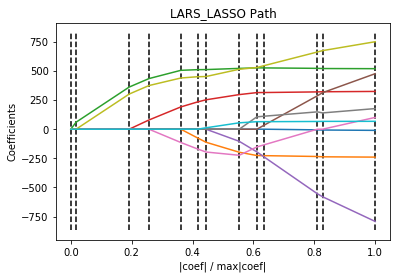

[2, 8, 3, 1, 9, 4, 7, 5, 0, 6]
[  -3045.5411149   -16719.0731136   493554.22332909  231855.34748865
 -271920.74019484  134339.63204362  -64582.16012207  123393.01965352
  688276.07769847   41875.18251093]


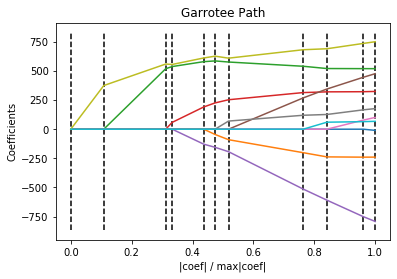

[8, 2, 3, 4, 1, 7, 5, 9, 6, 0]

In [20]:
X, y = datasets.load_diabetes(return_X_y=True)
# X = (X - np.shape(np.mean(X,axis = 0)))/np.std(X,axis = 0)
# y = y -np.mean(y)
linear = LinearRegression()
linear.fit(X,y)
beta_initials = linear.coef_
print(LAR_LASSO(X,y)[1])
NN_Garrotte(X,y,beta_initials)[0]